### Assess model performance post-training

#### Parameters

In [6]:
import os
import yaml

config = '/home/Thomas/ABC_expeditions_classifier/configs/ABC_experiment_2.yaml'
cfg = yaml.safe_load(open(config, 'r'))
split = 'test' # options are "train", "test", and "none"
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [2]:
import torch
import pandas as pd

import yaml

from ct_classifier.train import create_dataloader
from ct_classifier.dataset import CTDataset
from ct_classifier.model import CustomResNet50

cfg = yaml.safe_load(open(config, 'r'))
checkpoint_path="/home/Thomas/ABC_expeditions_classifier/model_states/ABC_experiment_2/best.pt"

# 1. Loading the model

device = cfg['device']

model = CustomResNet50(cfg['num_classes'])

# 2. Grab the latest model (if pre-trained model exists)

state = torch.load(open(checkpoint_path, 'rb'), map_location=device)
model.load_state_dict(state['model'])
model.to(device)
model.eval()

# 3. Prepare the data loader

dl_val = create_dataloader(cfg, split='test')

batch = next(iter(dl_val))


/home/Thomas/miniconda3/envs/ABC_expeditions_classifier/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/Thomas/miniconda3/envs/ABC_expeditions_classifier/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_2925071/4061025866.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling 

In [3]:
from torch.nn import Softmax
import numpy as np

prediction_labels = []
prediction_confs = []
true_labels = []
file_list = []
prediction_df_raw = []

label_dict = dl_val.dataset.inv_labels

for idx, (data, labels, file_names) in enumerate(dl_val):
  
  data = data.to(device)
  
  # Predict labels on validation data
  
  s = Softmax(dim=1)
  
  with torch.no_grad():
    prediction = model(data)
  
  prediction_raw = prediction # no softmax applied
  prediction_raw = prediction_raw.cpu().numpy()
  prediction_raw = pd.DataFrame(prediction_raw, columns=range(prediction_raw.shape[1]))

  prediction = s(prediction) # softmax applied

  pred_label = torch.argmax(prediction, dim=1)
  pred_label_conv = [label_dict[int(x.item())] for x in pred_label]
  pred_conf = prediction.max(dim = 1).values

  # Prepare dataframe 1
  prediction_raw.insert(0, "predicted_label", np.array(pred_label.cpu()))
  prediction_raw.insert(0, 'file_name', file_names)
  
  prediction_labels.append(pred_label.cpu().numpy())
  prediction_confs.append(pred_conf.cpu().numpy())
  
  # Get ground-truth labels 
  labels_conv = [label_dict[int(x.item())] for x in labels]
  true_labels.append(labels)
  file_list.append(file_names)

  prediction_df_raw.append(prediction_raw)

prediction_df_raw = pd.concat(prediction_df_raw, ignore_index=True)

prediction_df = {'pred_labels': np.hstack(prediction_labels),
                 "pred_confs" : np.hstack(prediction_confs), 
                 "true_labels": np.hstack(true_labels), 
                 "file_names": np.hstack(file_list)}
    
prediction_df = pd.DataFrame(prediction_df)

In [20]:
import torch

from ct_classifier.loss import map_indices

dictionaries = map_indices()

result = {}
for key, columns in dictionaries[1]["class"].items():
    result[key] = torch.sum(prediction[:, columns], dim=1)

new_tensor = np.column_stack([result[key].cpu().numpy() for key in dictionaries[1]["class"]])


In [6]:
import numpy as np

prediction_df.file_names.value_counts()

file_names
fb14f0c3-a476-46c4-b43b-3e563f994521_frame73_detection0     1
bbc97596-e036-4aca-8d7f-f20c88da022f_frame81_detection0     1
0bea4c33-ad2c-4349-a5d6-7a49d2faaa9d_frame54_detection0     1
43cdf13a-8c35-4f76-b069-f9b2901c8a16_frame83_detection0     1
a4a5bcd4-2a80-469d-9a0c-f68b4b8bf373_frame54_detection0     1
                                                           ..
16658dda-3ac0-452a-9994-1de24abc7054_frame0_detection0      1
7d149cd3-5032-4745-a217-83e189e94205_frame57_detection1     1
d367cd53-1fb0-4a9a-9597-d624c2a75d0b_frame14_detection0     1
c8ef7152-bfc1-4f04-8c72-fb07309aa3c9_frame71_detection0     1
4a5072a8-9c3f-444f-b2e0-615164af7dc8_frame104_detection1    1
Name: count, Length: 9100, dtype: int64

In [7]:
len(prediction_df)

9100

In [7]:
import yaml
from ct_classifier.train import create_dataloader

cfg = yaml.safe_load(open(config, 'r'))

dl_test = create_dataloader(cfg = cfg, split=split)

batch = next(iter(dl_test))



In [5]:
from ct_classifier.inference import model_inference

df_summary_train  = model_inference(config=cfg, 
                                     checkpoint_path="/home/Thomas/ABC_expeditions_classifier/model_states/ABC_experiment_2/best.pt", 
                                     split = "train", 
                                     type = "summary")

df_summary_test  = model_inference(config=cfg, 
                                     checkpoint_path="/home/Thomas/ABC_expeditions_classifier/model_states/ABC_experiment_2/best.pt", 
                                     split = "test", 
                                     type = "summary")

df_summary_test

/home/Thomas/miniconda3/envs/ABC_expeditions_classifier/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/Thomas/miniconda3/envs/ABC_expeditions_classifier/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/Thomas/ABC_expeditions_classifier/ct_classifier/inference.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arb

,pred_labels,pred_labels_full,pred_confs,true_labels,true_labels_full,file_names
0,10,peccary,0.999862,10,peccary,91eed319-4c7c-4e1f-8047-83a94c8e7505_frame63_d...
1,1,agouti-like,0.999664,1,agouti-like,a2e77c0c-5f73-46cb-ab95-ec55dc0a7dad_frame57_d...
2,2,tinamou,0.946884,2,tinamou,8393ccda-1d23-47ef-bb06-921bd308d94e_frame41_d...
3,6,trumpeter,0.999170,6,trumpeter,144f110a-b156-4ca4-9a73-cc1cb1533777_frame50_d...
4,7,brocket_deer,0.656632,7,brocket_deer,f01ae78d-bd17-481a-b50f-0e9daa884c56_frame72_d...
...,...,...,...,...,...,...
9095,7,brocket_deer,0.605626,26,southamerican_tapir,611c78bf-a15e-49a7-8324-abf2f5f7d6c5_frame91_d...
9096,7,brocket_deer,0.999806,7,brocket_deer,bbc97596-e036-4aca-8d7f-f20c88da022f_frame90_d...
9097,1,agouti-like,0.999314,16,squirrel,da411297-3465-40ef-b7b6-12598cc7c6e6_frame149_...
9098,6,trumpeter,0.998148,6,trumpeter,f3aff3e1-8a66-4012-be05-9b0c3e310723_frame36_d...


In [8]:
# Save the raw prediction scores for each sample as a csv

import os

target_folder = os.path.join(parent_dir, "posthoc_data")
target_filename = "raw_prediction_scores_val.csv"
target_path = os.path.join(target_folder, target_filename)
df_raw.to_csv(target_path, index=False, )


#### Make a confusion matrix

In [7]:
import yaml
from ct_classifier.train import create_dataloader

cfg = yaml.safe_load(open(config, 'r'))

dl_test = create_dataloader(cfg = cfg, split=split)


dl_test = create_dataloader(cfg = cfg, split=split)

inverse_dict = dl_test.dataset.inv_labels

inverse_dict



{0: 'curassow',
 1: 'agouti-like',
 2: 'tinamou',
 3: 'paca',
 4: 'southern_tamandua',
 5: 'spixs_guan',
 6: 'trumpeter',
 7: 'brocket_deer',
 8: 'longnosed_armadillo',
 9: 'coati',
 10: 'peccary',
 11: 'ocelot',
 12: 'margay',
 13: 'nonground_birds',
 14: 'jaguarundi',
 15: 'marsupial',
 16: 'squirrel',
 17: 'tayra',
 18: 'small_rodent',
 19: 'giant_anteater',
 20: 'giant_armadillo',
 21: 'nakedtailed_armadillo',
 22: 'shorteared_dog',
 23: 'puma',
 24: 'bats',
 25: 'crabeating_raccoon',
 26: 'southamerican_tapir',
 27: 'porcupine',
 28: 'ground_dove',
 29: 'jaguar'}

Text(0.5, 1.0, 'Normalized Confusion Matrix')

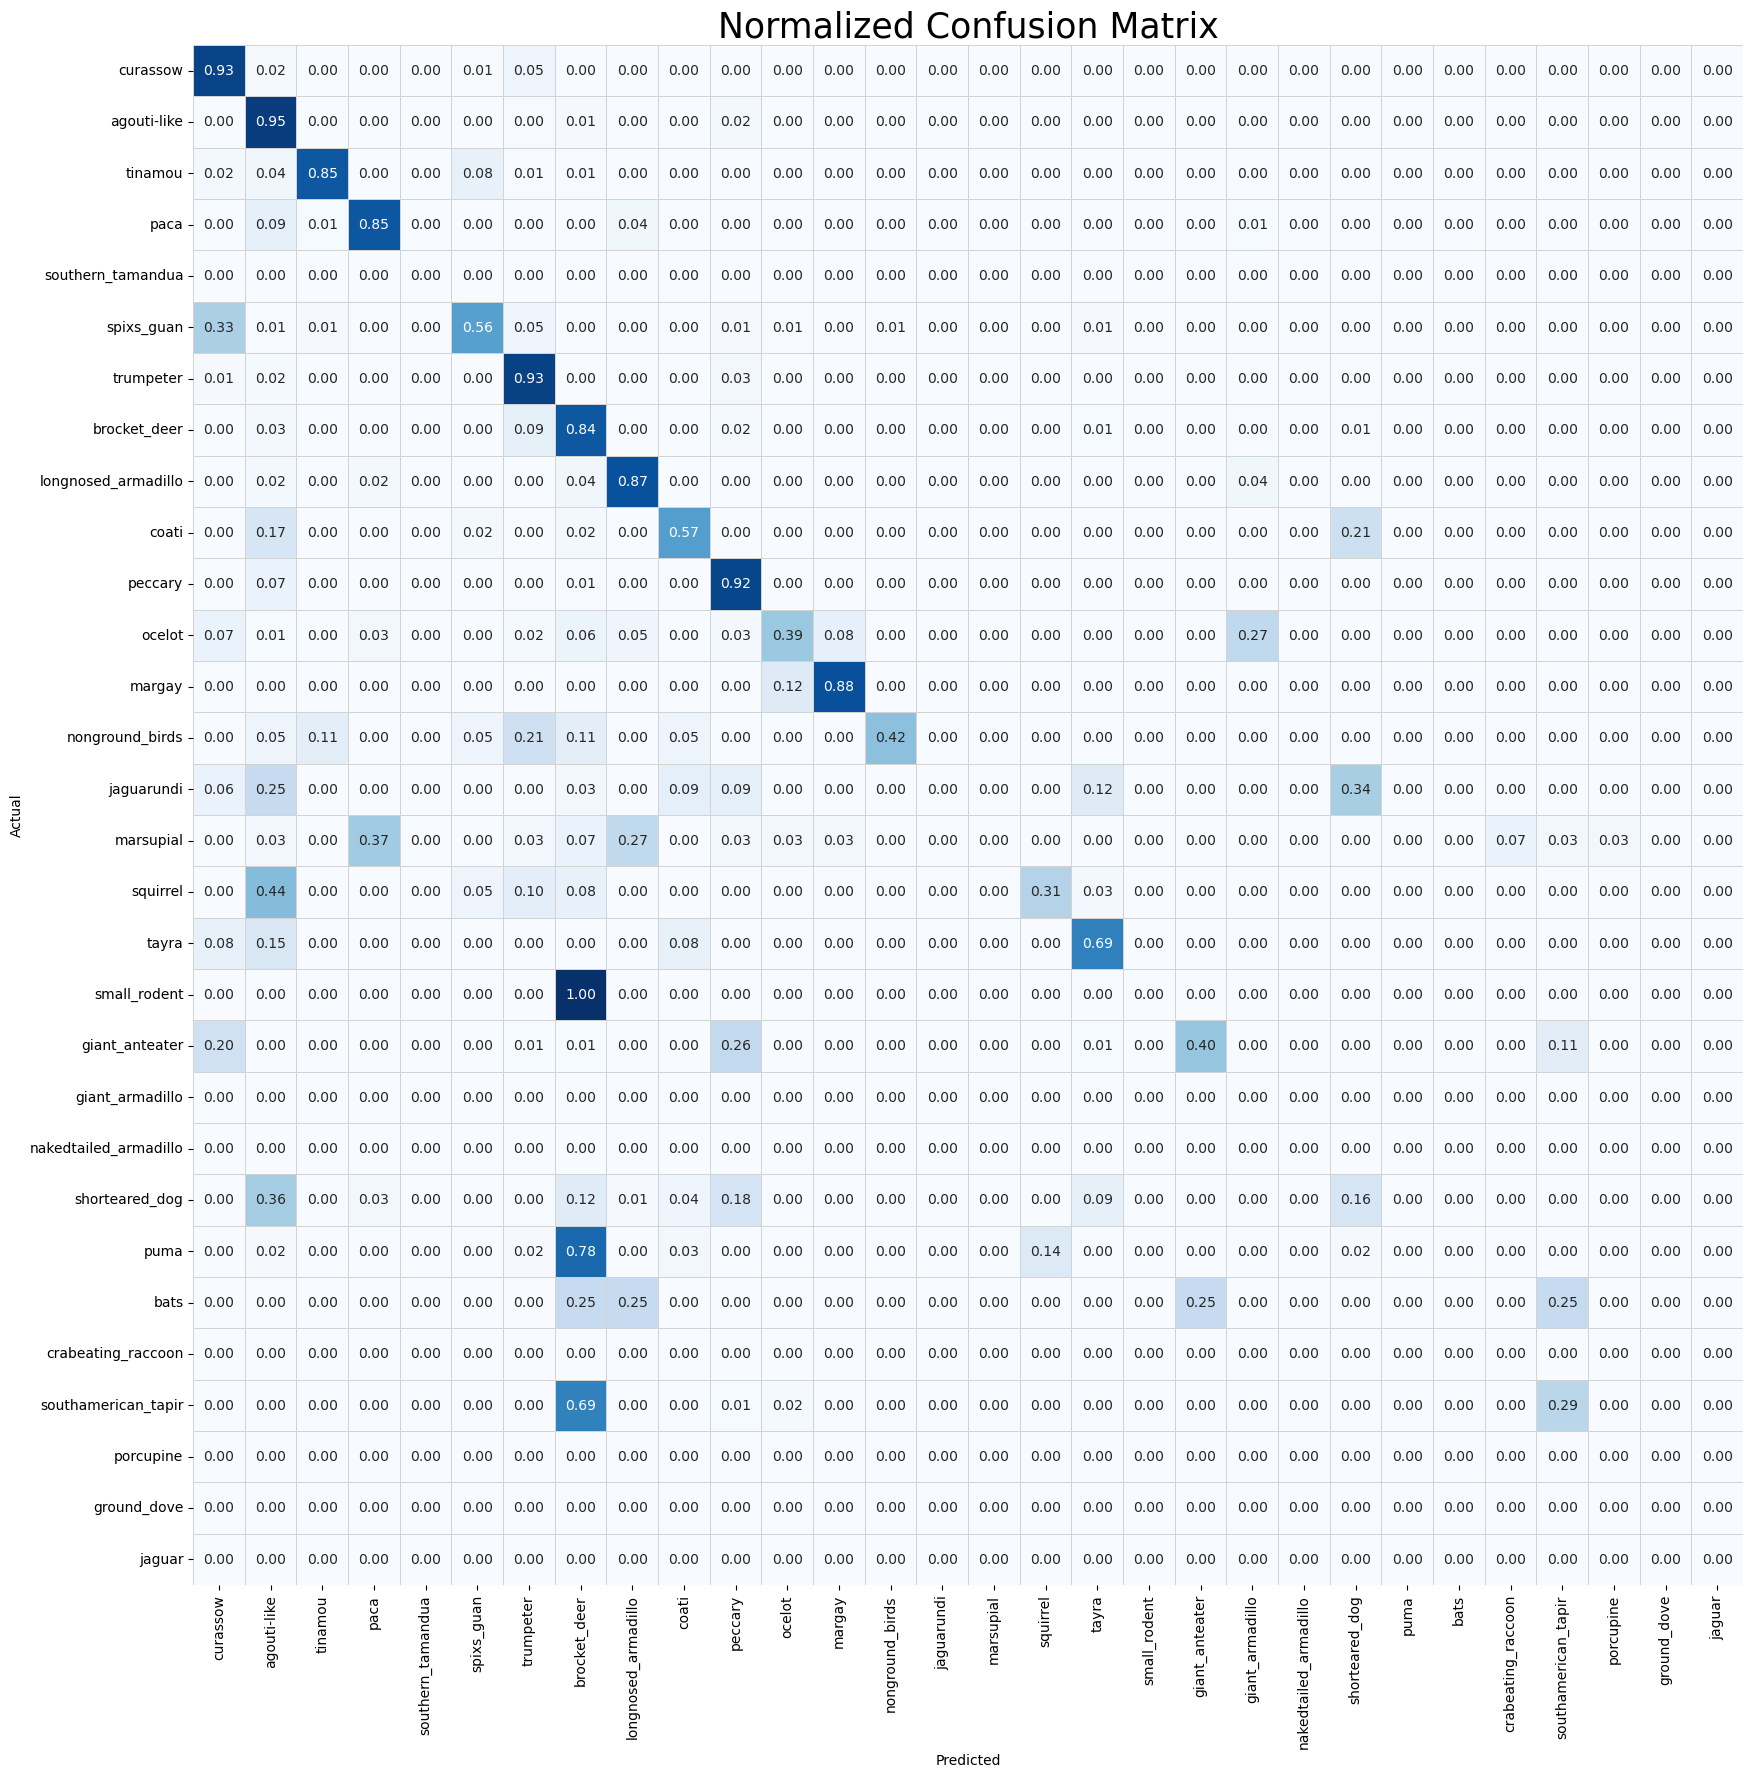

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np


# Assuming df_summary["true_labels_full"] and df_summary["pred_labels_full"] are pandas Series with categorical labels
true_labels = df_summary_test["true_labels_full"].unique()
pred_labels = df_summary_test["pred_labels_full"].unique()

# Ensure labels are in sorted order for consistent mapping (optional, depends on your use case)
#true_labels = np.sort(true_labels)
#pred_labels = np.sort(pred_labels)

labels_string = [inverse_dict[x] for x in range(len(inverse_dict))]

# Re-organize labels based on commonness:

order = df_summary_train["true_labels_full"].value_counts().reset_index()["true_labels_full"]



# Make confusion matrix

cm = confusion_matrix(df_summary_test["true_labels_full"], 
                      df_summary_test["pred_labels_full"],
                      labels=labels_string, 
                      normalize = "true")

# Ensures consistent label ordering)

#labels=true_labels,

# normalize="true"

#xticklabels=pred_labels, yticklabels=true_labels,

# Plot with labels
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cm, 
            annot=True, 
            fmt='.2f', 
            cmap="Blues", 
            xticklabels = labels_string, 
            yticklabels = labels_string, 
            linecolor='lightgrey',  # Add thin grey lines
            linewidths=0.5,
            cbar=False)     # Set the width of the lines)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix',size = 25)
#plt.show()

#### Make a annotation-mistakes plot (training data)

In [5]:
from ct_classifier.inference import model_inference

df_summary_train  = model_inference(config=cfg, 
                                     checkpoint_path="/home/Thomas/ABC_expeditions_classifier/model_states/experiment_4/best.pt", 
                                     split = "train", 
                                     type = "summary")

RuntimeError: Error(s) in loading state_dict for CustomResNet18:
	Unexpected key(s) in state_dict: "feature_extractor.layer1.2.conv1.weight", "feature_extractor.layer1.2.bn1.weight", "feature_extractor.layer1.2.bn1.bias", "feature_extractor.layer1.2.bn1.running_mean", "feature_extractor.layer1.2.bn1.running_var", "feature_extractor.layer1.2.bn1.num_batches_tracked", "feature_extractor.layer1.2.conv2.weight", "feature_extractor.layer1.2.bn2.weight", "feature_extractor.layer1.2.bn2.bias", "feature_extractor.layer1.2.bn2.running_mean", "feature_extractor.layer1.2.bn2.running_var", "feature_extractor.layer1.2.bn2.num_batches_tracked", "feature_extractor.layer1.2.conv3.weight", "feature_extractor.layer1.2.bn3.weight", "feature_extractor.layer1.2.bn3.bias", "feature_extractor.layer1.2.bn3.running_mean", "feature_extractor.layer1.2.bn3.running_var", "feature_extractor.layer1.2.bn3.num_batches_tracked", "feature_extractor.layer1.0.conv3.weight", "feature_extractor.layer1.0.bn3.weight", "feature_extractor.layer1.0.bn3.bias", "feature_extractor.layer1.0.bn3.running_mean", "feature_extractor.layer1.0.bn3.running_var", "feature_extractor.layer1.0.bn3.num_batches_tracked", "feature_extractor.layer1.0.downsample.0.weight", "feature_extractor.layer1.0.downsample.1.weight", "feature_extractor.layer1.0.downsample.1.bias", "feature_extractor.layer1.0.downsample.1.running_mean", "feature_extractor.layer1.0.downsample.1.running_var", "feature_extractor.layer1.0.downsample.1.num_batches_tracked", "feature_extractor.layer1.1.conv3.weight", "feature_extractor.layer1.1.bn3.weight", "feature_extractor.layer1.1.bn3.bias", "feature_extractor.layer1.1.bn3.running_mean", "feature_extractor.layer1.1.bn3.running_var", "feature_extractor.layer1.1.bn3.num_batches_tracked", "feature_extractor.layer2.2.conv1.weight", "feature_extractor.layer2.2.bn1.weight", "feature_extractor.layer2.2.bn1.bias", "feature_extractor.layer2.2.bn1.running_mean", "feature_extractor.layer2.2.bn1.running_var", "feature_extractor.layer2.2.bn1.num_batches_tracked", "feature_extractor.layer2.2.conv2.weight", "feature_extractor.layer2.2.bn2.weight", "feature_extractor.layer2.2.bn2.bias", "feature_extractor.layer2.2.bn2.running_mean", "feature_extractor.layer2.2.bn2.running_var", "feature_extractor.layer2.2.bn2.num_batches_tracked", "feature_extractor.layer2.2.conv3.weight", "feature_extractor.layer2.2.bn3.weight", "feature_extractor.layer2.2.bn3.bias", "feature_extractor.layer2.2.bn3.running_mean", "feature_extractor.layer2.2.bn3.running_var", "feature_extractor.layer2.2.bn3.num_batches_tracked", "feature_extractor.layer2.3.conv1.weight", "feature_extractor.layer2.3.bn1.weight", "feature_extractor.layer2.3.bn1.bias", "feature_extractor.layer2.3.bn1.running_mean", "feature_extractor.layer2.3.bn1.running_var", "feature_extractor.layer2.3.bn1.num_batches_tracked", "feature_extractor.layer2.3.conv2.weight", "feature_extractor.layer2.3.bn2.weight", "feature_extractor.layer2.3.bn2.bias", "feature_extractor.layer2.3.bn2.running_mean", "feature_extractor.layer2.3.bn2.running_var", "feature_extractor.layer2.3.bn2.num_batches_tracked", "feature_extractor.layer2.3.conv3.weight", "feature_extractor.layer2.3.bn3.weight", "feature_extractor.layer2.3.bn3.bias", "feature_extractor.layer2.3.bn3.running_mean", "feature_extractor.layer2.3.bn3.running_var", "feature_extractor.layer2.3.bn3.num_batches_tracked", "feature_extractor.layer2.0.conv3.weight", "feature_extractor.layer2.0.bn3.weight", "feature_extractor.layer2.0.bn3.bias", "feature_extractor.layer2.0.bn3.running_mean", "feature_extractor.layer2.0.bn3.running_var", "feature_extractor.layer2.0.bn3.num_batches_tracked", "feature_extractor.layer2.1.conv3.weight", "feature_extractor.layer2.1.bn3.weight", "feature_extractor.layer2.1.bn3.bias", "feature_extractor.layer2.1.bn3.running_mean", "feature_extractor.layer2.1.bn3.running_var", "feature_extractor.layer2.1.bn3.num_batches_tracked", "feature_extractor.layer3.2.conv1.weight", "feature_extractor.layer3.2.bn1.weight", "feature_extractor.layer3.2.bn1.bias", "feature_extractor.layer3.2.bn1.running_mean", "feature_extractor.layer3.2.bn1.running_var", "feature_extractor.layer3.2.bn1.num_batches_tracked", "feature_extractor.layer3.2.conv2.weight", "feature_extractor.layer3.2.bn2.weight", "feature_extractor.layer3.2.bn2.bias", "feature_extractor.layer3.2.bn2.running_mean", "feature_extractor.layer3.2.bn2.running_var", "feature_extractor.layer3.2.bn2.num_batches_tracked", "feature_extractor.layer3.2.conv3.weight", "feature_extractor.layer3.2.bn3.weight", "feature_extractor.layer3.2.bn3.bias", "feature_extractor.layer3.2.bn3.running_mean", "feature_extractor.layer3.2.bn3.running_var", "feature_extractor.layer3.2.bn3.num_batches_tracked", "feature_extractor.layer3.3.conv1.weight", "feature_extractor.layer3.3.bn1.weight", "feature_extractor.layer3.3.bn1.bias", "feature_extractor.layer3.3.bn1.running_mean", "feature_extractor.layer3.3.bn1.running_var", "feature_extractor.layer3.3.bn1.num_batches_tracked", "feature_extractor.layer3.3.conv2.weight", "feature_extractor.layer3.3.bn2.weight", "feature_extractor.layer3.3.bn2.bias", "feature_extractor.layer3.3.bn2.running_mean", "feature_extractor.layer3.3.bn2.running_var", "feature_extractor.layer3.3.bn2.num_batches_tracked", "feature_extractor.layer3.3.conv3.weight", "feature_extractor.layer3.3.bn3.weight", "feature_extractor.layer3.3.bn3.bias", "feature_extractor.layer3.3.bn3.running_mean", "feature_extractor.layer3.3.bn3.running_var", "feature_extractor.layer3.3.bn3.num_batches_tracked", "feature_extractor.layer3.4.conv1.weight", "feature_extractor.layer3.4.bn1.weight", "feature_extractor.layer3.4.bn1.bias", "feature_extractor.layer3.4.bn1.running_mean", "feature_extractor.layer3.4.bn1.running_var", "feature_extractor.layer3.4.bn1.num_batches_tracked", "feature_extractor.layer3.4.conv2.weight", "feature_extractor.layer3.4.bn2.weight", "feature_extractor.layer3.4.bn2.bias", "feature_extractor.layer3.4.bn2.running_mean", "feature_extractor.layer3.4.bn2.running_var", "feature_extractor.layer3.4.bn2.num_batches_tracked", "feature_extractor.layer3.4.conv3.weight", "feature_extractor.layer3.4.bn3.weight", "feature_extractor.layer3.4.bn3.bias", "feature_extractor.layer3.4.bn3.running_mean", "feature_extractor.layer3.4.bn3.running_var", "feature_extractor.layer3.4.bn3.num_batches_tracked", "feature_extractor.layer3.5.conv1.weight", "feature_extractor.layer3.5.bn1.weight", "feature_extractor.layer3.5.bn1.bias", "feature_extractor.layer3.5.bn1.running_mean", "feature_extractor.layer3.5.bn1.running_var", "feature_extractor.layer3.5.bn1.num_batches_tracked", "feature_extractor.layer3.5.conv2.weight", "feature_extractor.layer3.5.bn2.weight", "feature_extractor.layer3.5.bn2.bias", "feature_extractor.layer3.5.bn2.running_mean", "feature_extractor.layer3.5.bn2.running_var", "feature_extractor.layer3.5.bn2.num_batches_tracked", "feature_extractor.layer3.5.conv3.weight", "feature_extractor.layer3.5.bn3.weight", "feature_extractor.layer3.5.bn3.bias", "feature_extractor.layer3.5.bn3.running_mean", "feature_extractor.layer3.5.bn3.running_var", "feature_extractor.layer3.5.bn3.num_batches_tracked", "feature_extractor.layer3.0.conv3.weight", "feature_extractor.layer3.0.bn3.weight", "feature_extractor.layer3.0.bn3.bias", "feature_extractor.layer3.0.bn3.running_mean", "feature_extractor.layer3.0.bn3.running_var", "feature_extractor.layer3.0.bn3.num_batches_tracked", "feature_extractor.layer3.1.conv3.weight", "feature_extractor.layer3.1.bn3.weight", "feature_extractor.layer3.1.bn3.bias", "feature_extractor.layer3.1.bn3.running_mean", "feature_extractor.layer3.1.bn3.running_var", "feature_extractor.layer3.1.bn3.num_batches_tracked", "feature_extractor.layer4.2.conv1.weight", "feature_extractor.layer4.2.bn1.weight", "feature_extractor.layer4.2.bn1.bias", "feature_extractor.layer4.2.bn1.running_mean", "feature_extractor.layer4.2.bn1.running_var", "feature_extractor.layer4.2.bn1.num_batches_tracked", "feature_extractor.layer4.2.conv2.weight", "feature_extractor.layer4.2.bn2.weight", "feature_extractor.layer4.2.bn2.bias", "feature_extractor.layer4.2.bn2.running_mean", "feature_extractor.layer4.2.bn2.running_var", "feature_extractor.layer4.2.bn2.num_batches_tracked", "feature_extractor.layer4.2.conv3.weight", "feature_extractor.layer4.2.bn3.weight", "feature_extractor.layer4.2.bn3.bias", "feature_extractor.layer4.2.bn3.running_mean", "feature_extractor.layer4.2.bn3.running_var", "feature_extractor.layer4.2.bn3.num_batches_tracked", "feature_extractor.layer4.0.conv3.weight", "feature_extractor.layer4.0.bn3.weight", "feature_extractor.layer4.0.bn3.bias", "feature_extractor.layer4.0.bn3.running_mean", "feature_extractor.layer4.0.bn3.running_var", "feature_extractor.layer4.0.bn3.num_batches_tracked", "feature_extractor.layer4.1.conv3.weight", "feature_extractor.layer4.1.bn3.weight", "feature_extractor.layer4.1.bn3.bias", "feature_extractor.layer4.1.bn3.running_mean", "feature_extractor.layer4.1.bn3.running_var", "feature_extractor.layer4.1.bn3.num_batches_tracked". 
	size mismatch for feature_extractor.layer1.0.conv1.weight: copying a param with shape torch.Size([64, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for feature_extractor.layer1.1.conv1.weight: copying a param with shape torch.Size([64, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for feature_extractor.layer2.0.conv1.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for feature_extractor.layer2.0.downsample.0.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for feature_extractor.layer2.0.downsample.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for feature_extractor.layer2.0.downsample.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for feature_extractor.layer2.0.downsample.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for feature_extractor.layer2.0.downsample.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for feature_extractor.layer2.1.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for feature_extractor.layer3.0.conv1.weight: copying a param with shape torch.Size([256, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for feature_extractor.layer3.0.downsample.0.weight: copying a param with shape torch.Size([1024, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for feature_extractor.layer3.0.downsample.1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for feature_extractor.layer3.0.downsample.1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for feature_extractor.layer3.0.downsample.1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for feature_extractor.layer3.0.downsample.1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for feature_extractor.layer3.1.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for feature_extractor.layer4.0.conv1.weight: copying a param with shape torch.Size([512, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 3, 3]).
	size mismatch for feature_extractor.layer4.0.downsample.0.weight: copying a param with shape torch.Size([2048, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for feature_extractor.layer4.0.downsample.1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for feature_extractor.layer4.0.downsample.1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for feature_extractor.layer4.0.downsample.1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for feature_extractor.layer4.0.downsample.1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for feature_extractor.layer4.1.conv1.weight: copying a param with shape torch.Size([512, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for classifier.weight: copying a param with shape torch.Size([30, 2048]) from checkpoint, the shape in current model is torch.Size([30, 512]).

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import colorcet as cc

n_annotations = df_summary_train['true_labels_full'].value_counts()

mismatches_df = pd.DataFrame({"true_label":df_summary_train['true_labels_full'],
                              "mismatch":(df_summary_train['pred_labels_full'] != df_summary_train['true_labels_full'])})


mismatches_df = pd.merge(mismatches_df.groupby("true_label").sum().reset_index("true_label"), 
                        mismatches_df["true_label"].value_counts().reset_index("true_label"), 
                        on='true_label')

mismatches_df["percentage_mistakes"] = (mismatches_df["mismatch"] / mismatches_df["count"])*100

mismatches_df

,true_label,mismatch,count,percentage_mistakes
0,agouti-like,1,3931,0.025439
1,bats,5,5,100.000000
2,brocket_deer,1,3720,0.026882
3,coati,1,249,0.401606
4,crabeating_raccoon,1,15,6.666667
5,curassow,1,1469,0.068074
6,giant_anteater,3,85,3.529412
7,giant_armadillo,3,135,2.222222
8,ground_dove,0,14,0.000000
9,jaguar,0,22,0.000000


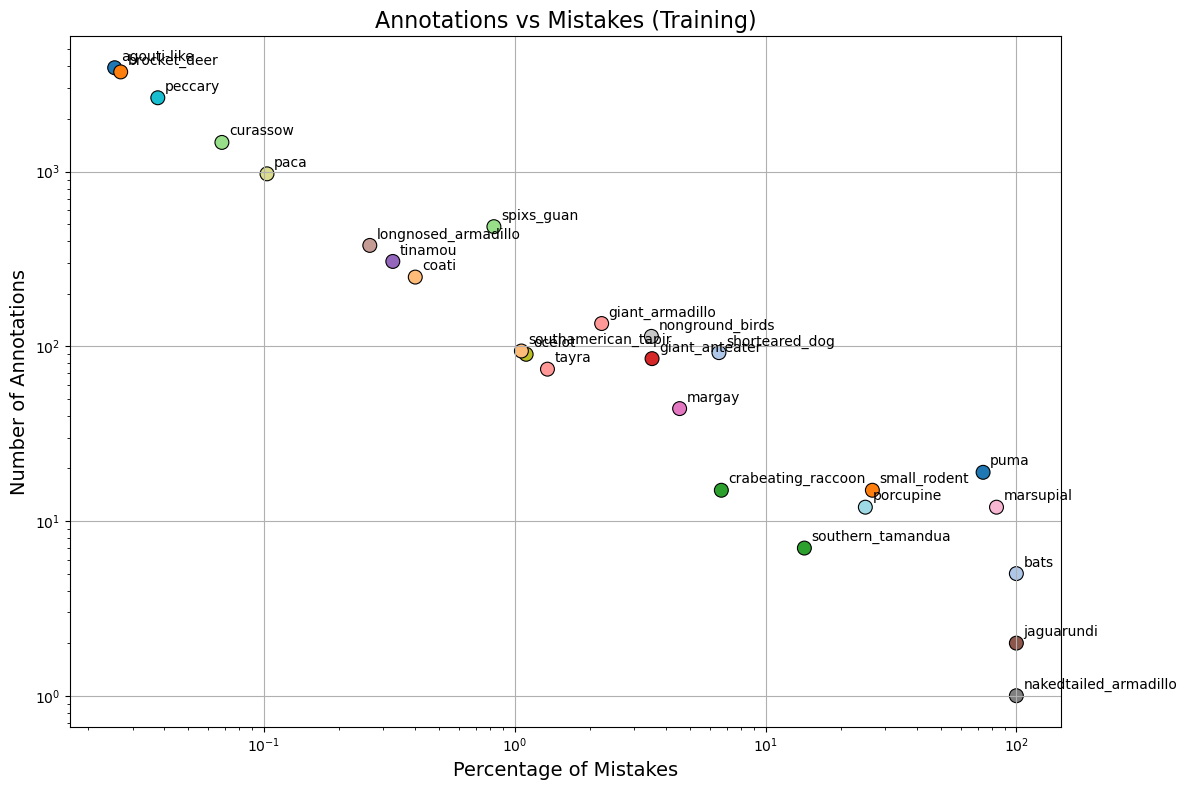

In [10]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import colorcet as cc

n_annotations = df_summary_train['true_labels_full'].value_counts()

mismatches_df = pd.DataFrame({"true_label":df_summary_train['true_labels_full'],
                              "mismatch":(df_summary_train['pred_labels_full'] != df_summary_train['true_labels_full'])})


mismatches_df = pd.merge(mismatches_df.groupby("true_label").sum().reset_index("true_label"), 
                        mismatches_df["true_label"].value_counts().reset_index("true_label"), 
                        on='true_label')

mismatches_df["percentage_mistakes"] = (mismatches_df["mismatch"] / mismatches_df["count"])*100

mismatches_df

# Step 4: Plot using Seaborn
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(
    data=mismatches_df,
    x='percentage_mistakes',
    y='count',
    hue='true_label',
    palette='tab20',  # Categorical palette
    edgecolor='k',
    s=100  # Size of markers
)

# Remove the legend
scatter_plot.legend_.remove()

# Add labels next to each point
for i, row in mismatches_df.iterrows():
    plt.annotate(
        text=row['true_label'],
        xy=(row['percentage_mistakes'], row['count']),
        xytext=(5, 5),  # Offset label slightly
        textcoords='offset points',
        fontsize=10,
        color='black'
    )

# Enhance plot aesthetics
scatter_plot.set_title("Annotations vs Mistakes (Training)", fontsize=16)
scatter_plot.set_xlabel("Percentage of Mistakes", fontsize=14)
scatter_plot.set_ylabel("Number of Annotations", fontsize=14)
scatter_plot.grid(True)

plt.xscale('log')
plt.yscale('log')

# Show plot
plt.tight_layout()
plt.show()